In [1]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from PIL import Image
import matplotlib.pyplot as plt
import os, sys

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

flx_data_path = "/work/mk423/Anxiety/final_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/hpc/home/mk423/Anxiety/FullDataWork/Models/"
saved_model_name = "nobal_unsup_NMF_check.pt"

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/UnsupNets/"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]

RANDOM_STATE = 42

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']

In [3]:
with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [4]:
with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train_task,X_val_task])
epm_y_task = np.hstack([y_train_task,y_val_task])
epm_y_mouse = np.hstack([y_mouse_train_task,y_mouse_val_task])
epm_y_time = np.hstack([y_time_train_task,y_time_val_task])


In [5]:
mt_X_train = np.vstack([flx_X_train[flx_y_hab_train==1],oft_X_train,X_train])
mt_y_train = np.hstack([flx_y_train[flx_y_hab_train==1],oft_y_task_train,y_in_task_mask_train]).reshape(-1,1)
mt_y_train_20_net = np.hstack([mt_y_train for i in range(20)])
mt_y_mouse_train = np.hstack([flx_y_mouse_train[flx_y_hab_train==1],oft_y_mouse_train,y_mouse_train])

mt_X_val = np.vstack([flx_X_val[flx_y_hab_val==1],oft_X_val,X_val])
mt_y_val = np.hstack([flx_y_val[flx_y_hab_val==1],oft_y_task_val,y_in_task_mask_val]).reshape(-1,1)
mt_y_val_20_net = np.hstack([mt_y_val for i in range(20)])
mt_y_mouse_val = np.hstack([flx_y_mouse_val[flx_y_hab_val==1],oft_y_mouse_val,y_mouse_val])

mt_X_test = np.vstack([flx_X_test[flx_y_hab_test==1],oft_X_test,X_test])
mt_y_test = np.hstack([flx_y_test[flx_y_hab_test==1],oft_y_task_test,y_in_task_mask_test]).reshape(-1,1)
mt_y_test_2_net = np.hstack((mt_y_test,mt_y_test))
mt_y_mouse_test = np.hstack([flx_y_mouse_test[flx_y_hab_test==1],oft_y_mouse_test,y_mouse_test])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))
nmf_groups = np.hstack(
    [
        np.ones(flx_X_train[flx_y_hab_train==1].shape[0])*0,
        np.ones(oft_X_train.shape[0]),
        np.ones(X_train.shape[0])*2
    ]
)

    

In [6]:
TRAIN = True

if TRAIN:
    model = DcsfaNmf(
        n_components=30,
        n_sup_networks=20,
        sup_type="sc",
        n_intercepts=intercept_mask.shape[1],
        optim_name="SGD",
        recon_loss="MSE",
        feature_groups=feature_groups,
        fixed_corr=["positive" for i in range(20)],
        save_folder=saved_model_path,
    )

    model.fit(mt_X_train,
              mt_y_train,
              intercept_mask=intercept_mask,
              y_sample_groups=nmf_groups,
              batch_size=128,
              lr=1e-3,
              n_pre_epochs=1,
              n_epochs=1,
              nmf_max_iter=10000,
              pretrain=True,
              verbose=True,
              X_val=mt_X_val,
              y_val=mt_y_val,
              best_model_name=saved_model_name)

    torch.save(model,saved_model_path + saved_model_name)
    
else:
    model = torch.load(saved_model_path + saved_model_name)

Pretraining NMF...
Identifying predictive components for supervised network 0


100%|██████████| 30/30 [00:00<00:00, 35.64it/s]


Selecting network: 19 with auc 0.5463959818874385 for sup net 0 using constraint positive correlation
Identifying predictive components for supervised network 1


100%|██████████| 30/30 [00:00<00:00, 35.65it/s]


Selecting network: 2 with auc 0.5316663276828181 for sup net 1 using constraint positive correlation
Identifying predictive components for supervised network 2


100%|██████████| 30/30 [00:00<00:00, 36.85it/s]


Selecting network: 24 with auc 0.5316061452091352 for sup net 2 using constraint positive correlation
Identifying predictive components for supervised network 3


100%|██████████| 30/30 [00:00<00:00, 37.61it/s]


Selecting network: 18 with auc 0.5302919779775541 for sup net 3 using constraint positive correlation
Identifying predictive components for supervised network 4


100%|██████████| 30/30 [00:00<00:00, 36.42it/s]


Selecting network: 3 with auc 0.526325546017784 for sup net 4 using constraint positive correlation
Identifying predictive components for supervised network 5


100%|██████████| 30/30 [00:00<00:00, 36.15it/s]


Selecting network: 12 with auc 0.5198342986721847 for sup net 5 using constraint positive correlation
Identifying predictive components for supervised network 6


100%|██████████| 30/30 [00:00<00:00, 38.87it/s]


Selecting network: 5 with auc 0.5177449184286534 for sup net 6 using constraint positive correlation
Identifying predictive components for supervised network 7


100%|██████████| 30/30 [00:00<00:00, 38.31it/s]


Selecting network: 1 with auc 0.5150294263721519 for sup net 7 using constraint positive correlation
Identifying predictive components for supervised network 8


100%|██████████| 30/30 [00:00<00:00, 38.43it/s]


Selecting network: 25 with auc 0.5145882204579044 for sup net 8 using constraint positive correlation
Identifying predictive components for supervised network 9


100%|██████████| 30/30 [00:00<00:00, 38.15it/s]


Selecting network: 16 with auc 0.513193282352613 for sup net 9 using constraint positive correlation
Identifying predictive components for supervised network 10


100%|██████████| 30/30 [00:00<00:00, 38.68it/s]


Selecting network: 11 with auc 0.510860576861992 for sup net 10 using constraint positive correlation
Identifying predictive components for supervised network 11


100%|██████████| 30/30 [00:00<00:00, 37.63it/s]


Selecting network: 22 with auc 0.5087593520841176 for sup net 11 using constraint positive correlation
Identifying predictive components for supervised network 12


100%|██████████| 30/30 [00:00<00:00, 37.94it/s]


Selecting network: 13 with auc 0.5078077139158483 for sup net 12 using constraint positive correlation
Identifying predictive components for supervised network 13


100%|██████████| 30/30 [00:00<00:00, 38.15it/s]


Selecting network: 17 with auc 0.5067190772228277 for sup net 13 using constraint positive correlation
Identifying predictive components for supervised network 14


100%|██████████| 30/30 [00:00<00:00, 36.17it/s]


Selecting network: 7 with auc 0.5064773536390407 for sup net 14 using constraint positive correlation
Identifying predictive components for supervised network 15


100%|██████████| 30/30 [00:00<00:00, 33.00it/s]


Selecting network: 27 with auc 0.5020821513300685 for sup net 15 using constraint positive correlation
Identifying predictive components for supervised network 16


100%|██████████| 30/30 [00:00<00:00, 36.89it/s]


Selecting network: 28 with auc 0.49522864502119146 for sup net 16 using constraint positive correlation
Identifying predictive components for supervised network 17


100%|██████████| 30/30 [00:00<00:00, 37.00it/s]


Selecting network: 4 with auc 0.4922156352852673 for sup net 17 using constraint positive correlation
Identifying predictive components for supervised network 18


100%|██████████| 30/30 [00:00<00:00, 36.56it/s]


Selecting network: 29 with auc 0.488202624524757 for sup net 18 using constraint positive correlation
Identifying predictive components for supervised network 19


100%|██████████| 30/30 [00:00<00:00, 36.75it/s]


Selecting network: 14 with auc 0.4875525226460141 for sup net 19 using constraint positive correlation


Encoder Pretrain Epoch: 0, Recon Loss: 5.53163: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Beginning Training


Epoch: 0, Best Epoch: 0, Best Val MSE: 0.0809598, Best Val by Window ROC-AUC [0.4792866956454427], current MSE: 0.0809598, current AUC: [0.4792866956454427]: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]

Saving the last epoch with training MSE: 0.081597 and AUCs:[0.49143434253084883]
Loaded the best model from Epoch: 0 with MSE: 0.0809598 and AUCs: [0.4792866956454427]


Val MSE: 0.029828115874783893
0 19


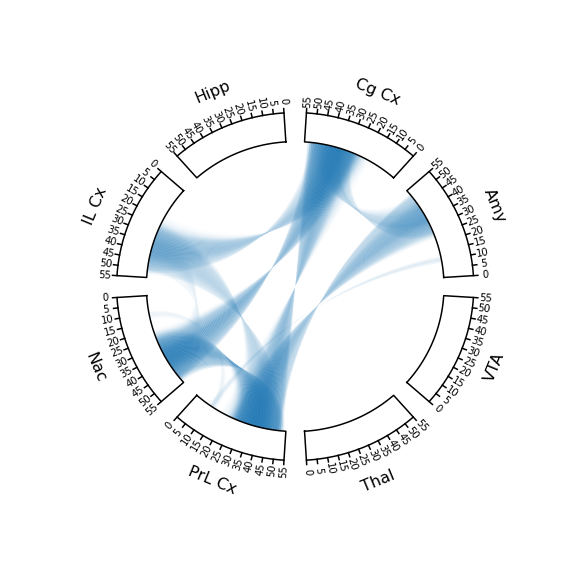

1 2


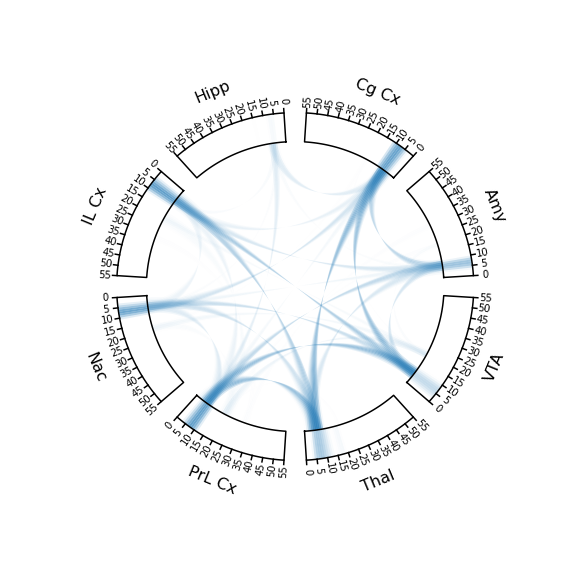

2 24


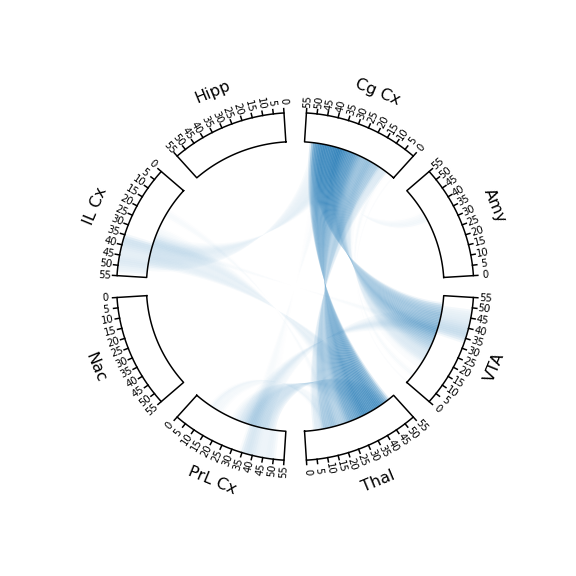

3 18


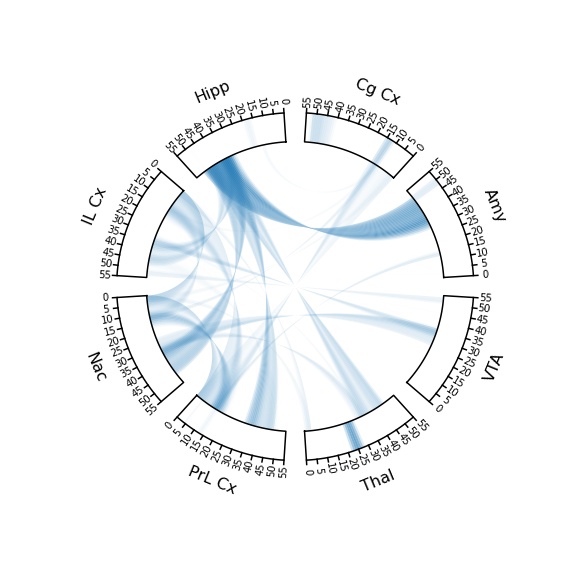

4 3


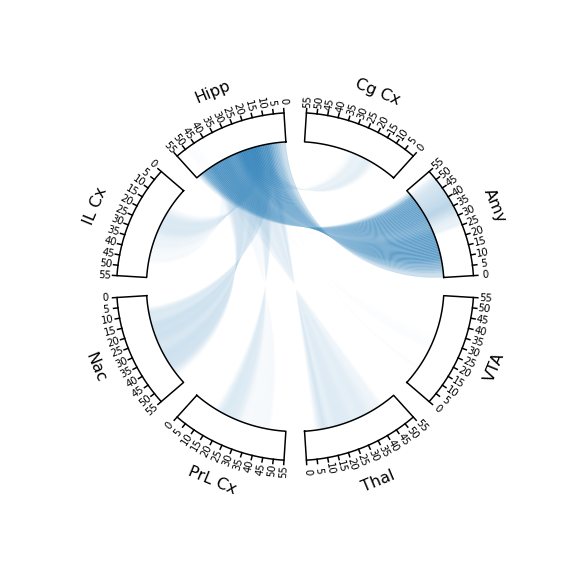

5 12


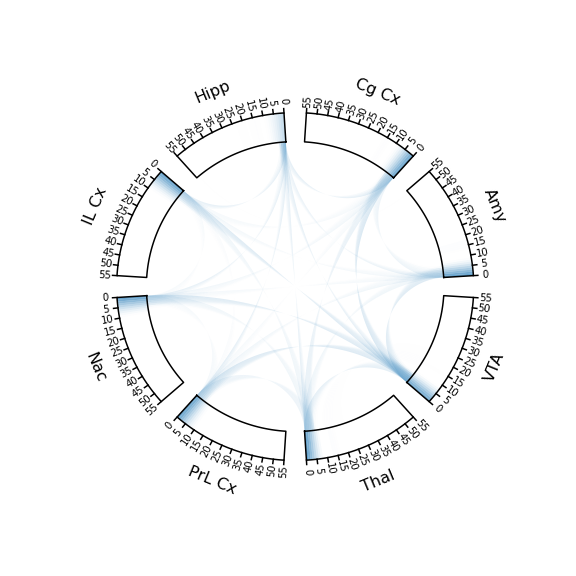

6 5


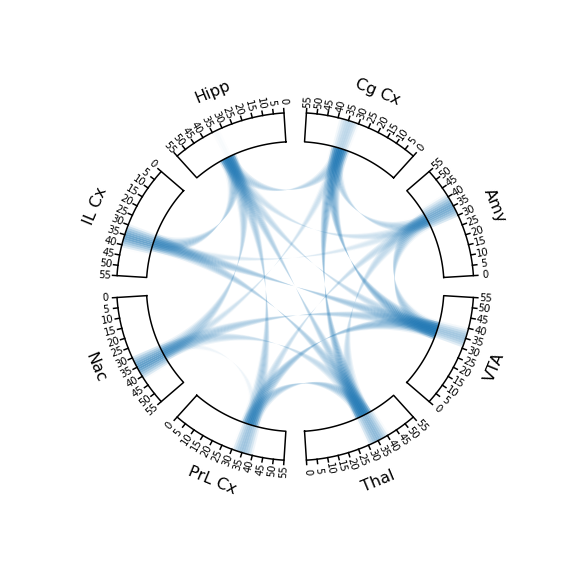

7 1


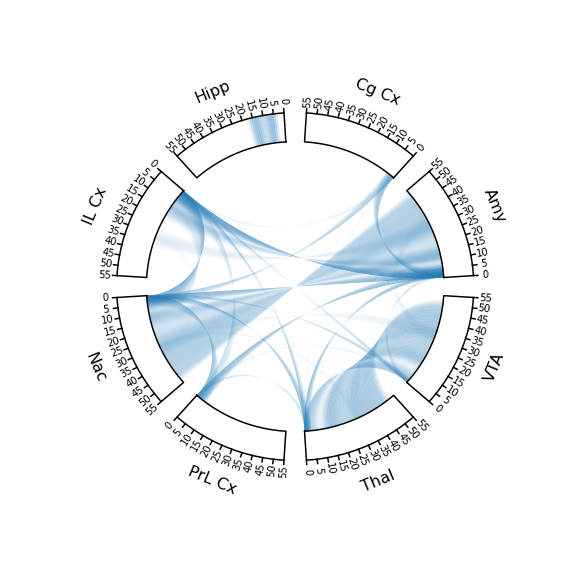

8 25


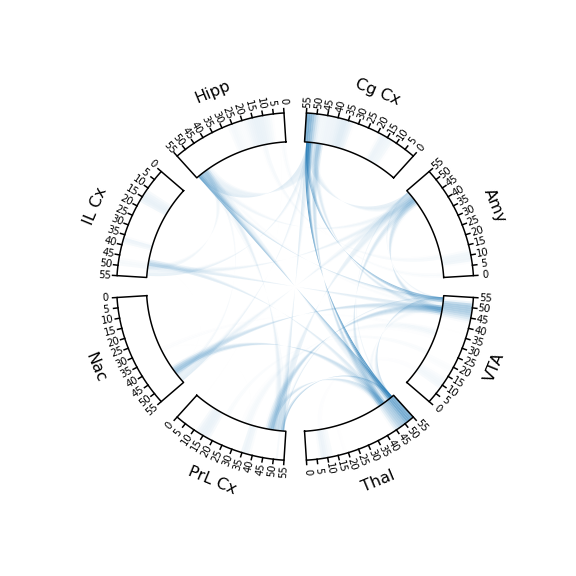

9 16


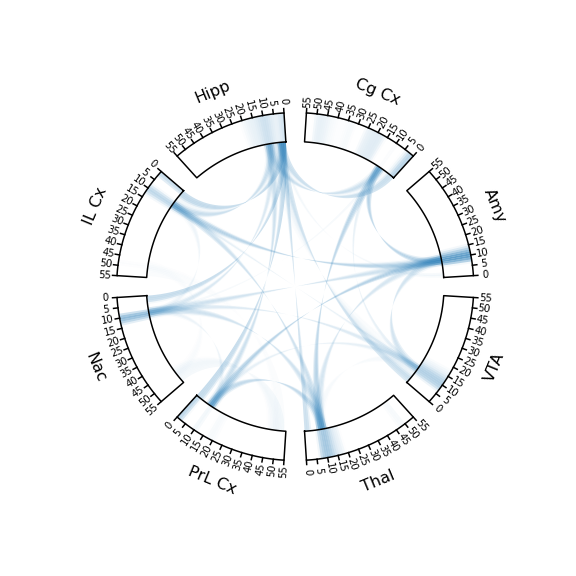

10 11


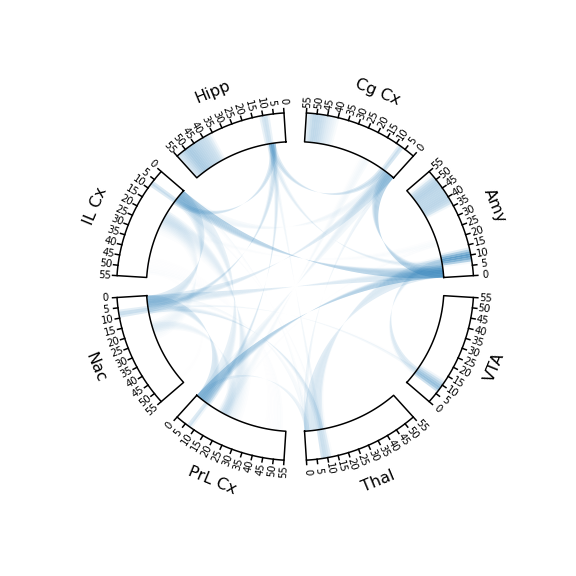

11 22


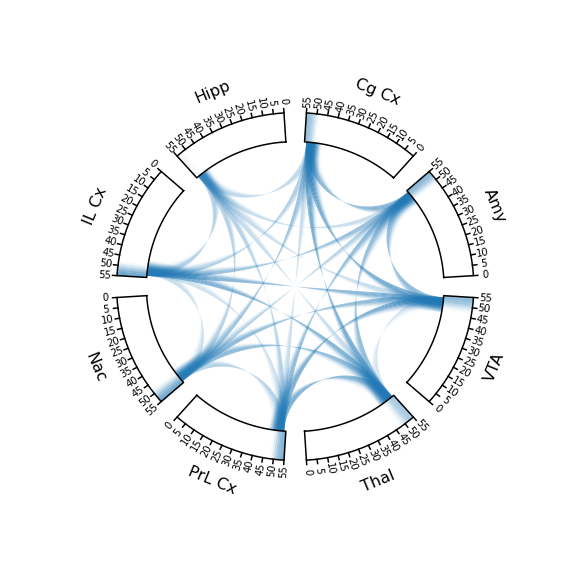

12 13


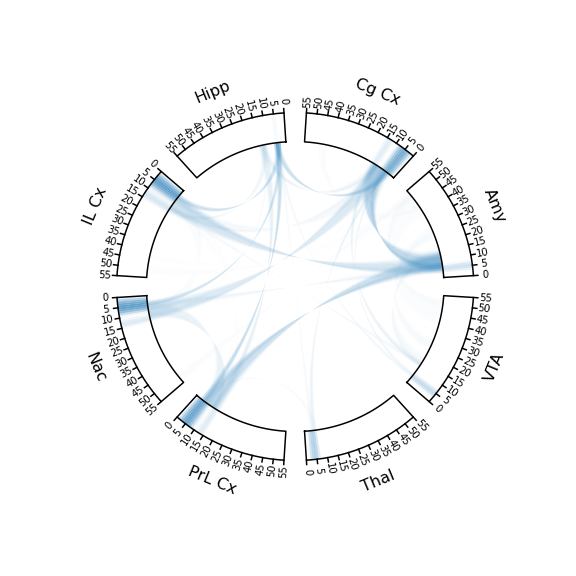

13 17


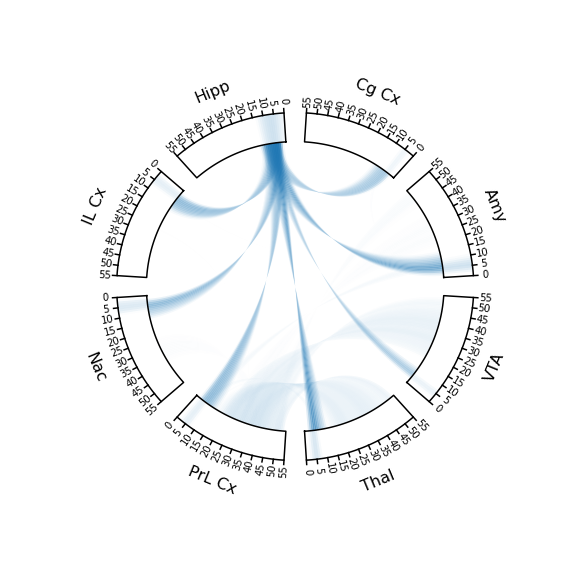

14 7


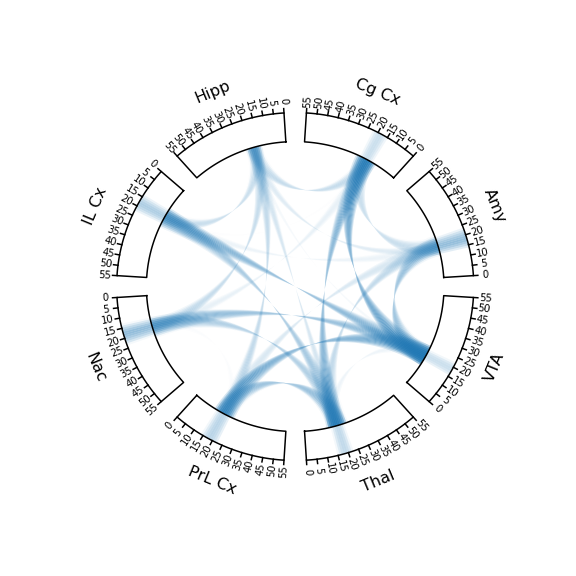

15 27


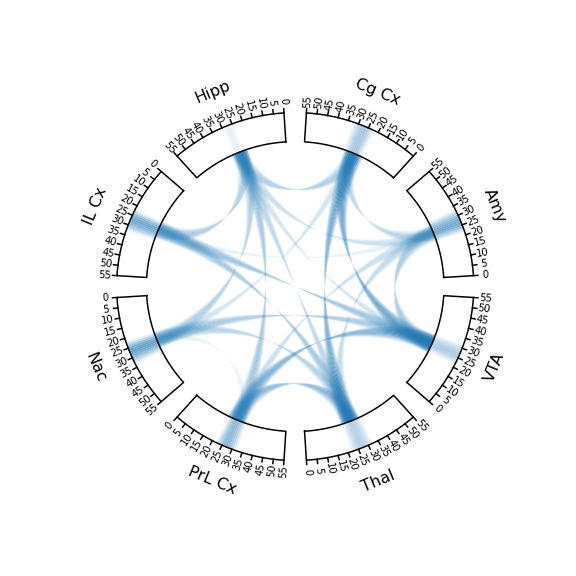

16 28


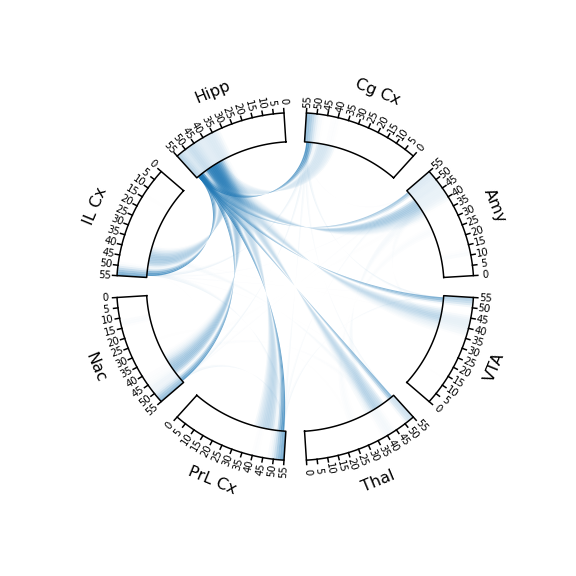

17 4


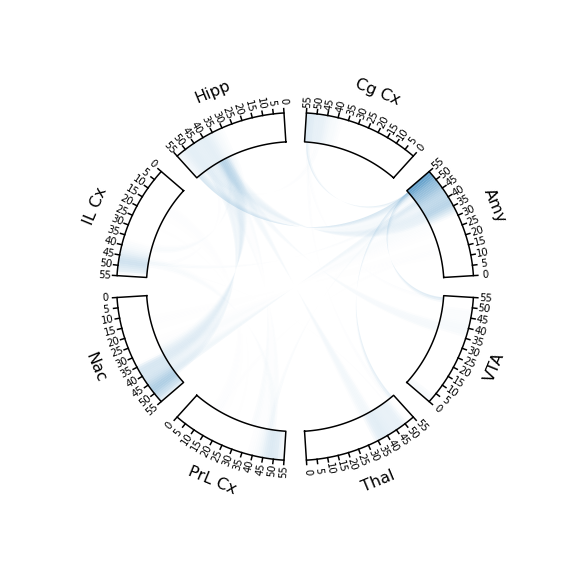

18 29


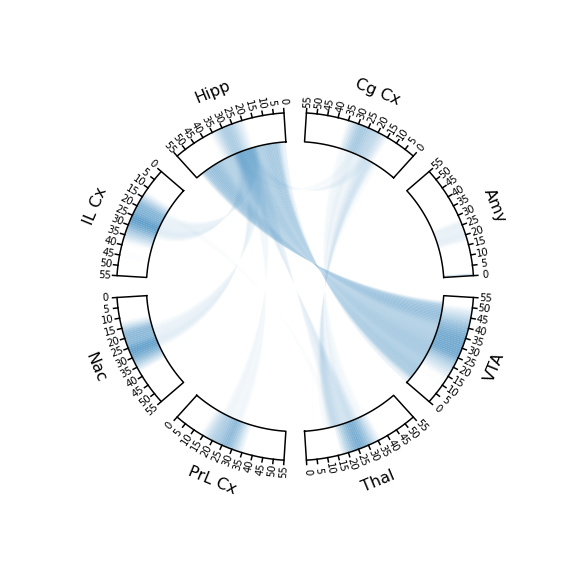

19 14


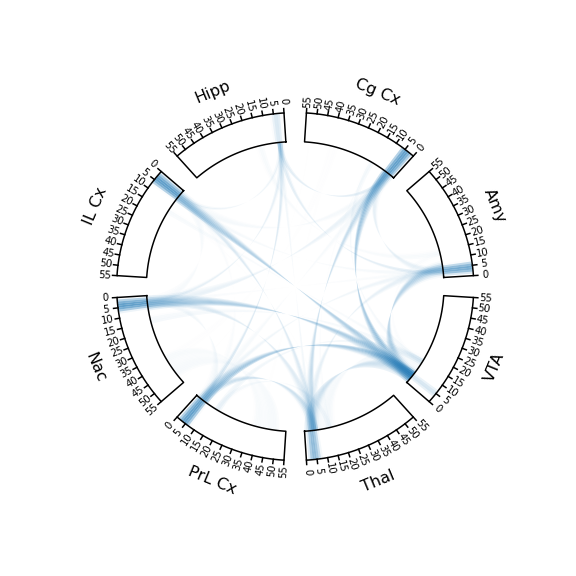

In [7]:
def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
    X_3d = np.zeros((n_rois,n_rois,n_freqs))
    
    for i in range(n_rois):
        X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]
        
    
    split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
    #print(split_coh_features)
    unique_coh_features = np.unique(split_coh_features)
    for i in range(n_rois):
        for j in range(n_rois):
            if i != j:
                area_1 = areas[i]
                area_2 = areas[j]
                temp_feature = area_1 + "-" + area_2
                temp_feature_2 = area_2 + "-" + area_1
                if temp_feature in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature,True,False)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                elif temp_feature_2 in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                else:
                    print("temp_feature: {} not found".format(temp_feature))

    return X_3d

with open("/work/mk423/Anxiety/Anx_Info_Dict.pkl","rb") as f:
    anxInfo = pickle.load(f)
    
s=model.NMF_init.transform(mt_X_val)
full_recon = s @ model.NMF_init.components_ + 1e-6
mse = np.mean((mt_X_val - full_recon)**2)
print("Val MSE: {}".format(mse))

for i in range(20):
    sel_net = model.skl_pretrain_networks_[i]
    sel_auc = model.skl_pretrain_aucs_[i]
    
    sup_recon = s[:,i].reshape(-1,1) @ model.NMF_init.components_[i,:].reshape(1,-1) + 1e-6
    
    recon_contribution = np.mean(sup_recon/full_recon,axis=0)
    rec_psd = recon_contribution[:len(anxInfo["powerFeatures"])]
    rec_coh = recon_contribution[len(anxInfo["powerFeatures"]):(len(anxInfo["powerFeatures"]) + len(anxInfo["cohFeatures"]))]
    rec_3d = reshapeData(rec_psd,rec_coh,8,56,anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["area"])
    
    circle_plot(rec_3d,anxInfo["area"],freqs=np.arange(56),freq_ticks=np.arange(0,56,5),min_max_quantiles=(0.85,0.9999),fn=plots_path + "unbal_nmf_init_pIdx_{}_nIdx_{}.png".format(i,sel_net))
    print(i,sel_net)
    image = Image.open(plots_path + "unbal_nmf_init_pIdx_{}_nIdx_{}.png".format(i,sel_net))
    image.show()